# Natural Language Processing for the Fake News Challenge

## Main Imports

In [ ]:
import torch
import string
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

from google.colab import drive
drive.mount('/content/drive')

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, LeakyReLU, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

!pip install transformers
import transformers

Mounted at /content/drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 2.3MB 5.6MB/s 
     |████████████████████████████████| 901kB 48.5MB/s 
     |████████████████████████████████| 3.3MB 50.5MB/s 


## Set up the data for preprocessing

### Load the data

In [ ]:
main_path = '/content/drive/My Drive/University Work/Year 4/Natural Language Processing/'
data_folder_name = 'data/'

train_body_filename = 'train_bodies.csv'
train_stance_filename = 'train_stances.csv'
test_body_filename = 'competition_test_bodies.csv'
test_stance_filename = 'competition_test_stances.csv'

train_body_path = main_path + data_folder_name + train_body_filename 
train_stance_path = main_path + data_folder_name + train_stance_filename
test_body_path = main_path + data_folder_name + test_body_filename
test_stance_path = main_path + data_folder_name + test_stance_filename

train_body_data = pd.read_csv(train_body_path)
train_stance_data = pd.read_csv(train_stance_path)
test_body_data = pd.read_csv(test_body_path)
test_stance_data = pd.read_csv(test_stance_path)

### Data Preprocessing

In [ ]:
def preprocess(text):

    text = nltk.tokenize.word_tokenize(text)
    text = [word for word in text if word not in nltk.corpus.stopwords.words('english')]
    text = (" ").join(text)

    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)

    ps = nltk.stem.PorterStemmer()
    text = nltk.tokenize.word_tokenize(text)

    text = [ps.stem(word) for word in text]
    text = (" ").join(text)

    return text

In [ ]:
train_body_data['articleBody'] = train_body_data['articleBody'].apply(lambda x: preprocess(x))
train_stance_data['Headline'] = train_stance_data['Headline'].apply(lambda x: preprocess(x))
test_body_data['articleBody'] = test_body_data['articleBody'].apply(lambda x: preprocess(x))
test_stance_data['Headline'] = test_stance_data['Headline'].apply(lambda x: preprocess(x))

### Merge the data based on the Body ID to get one dataframe containing the corresponding Headlines and Article Bodies with a Relevance column

In [ ]:
train_total_data = pd.merge(train_body_data, train_stance_data, on='Body ID')
train_total_data['Relevance'] = np.where(train_total_data['Stance'] == 'unrelated', 0, 1)

test_total_data = pd.merge(test_body_data, test_stance_data, on='Body ID')
test_total_data['Relevance'] = np.where(test_total_data['Stance'] == 'unrelated', 0, 1)

train_total_data.sample(10)

,Body ID,articleBody,Headline,Stance,Relevance
26259,1478,dylan thoma found spider burrow way scar A you...,tropic spider burrow man s skin live three day,agree,1
7603,480,former major leagu basebal outfield jose canse...,appl reportedli prepar 12inch macbook air thin...,unrelated,0
13822,825,defens secretari chuck hagel said saturday US ...,guantanamo detaine freed bow bergdahl swap bac...,unrelated,0
11065,682,there shoot war memori parliament hill unconfi...,hospit man treat ebola kansa citi,unrelated,0
17296,1019,christian bale star late appl ceo steve job up...,boko haram deni truce say kidnap girl marri,unrelated,0
39665,2096,islam state milit releas graphic video alleged...,break new isi behead miss american journalist ...,discuss,1
47872,2445,It ’ eyeballgrab headlin “ god woman priest di...,conflict report alleg IS captur canadian woman,unrelated,0
9684,591,cnn scratch christian bale list actor suppos p...,christian bale play steve job,agree,1
37420,1996,It start somewhat cynic social experi orang co...,sugarhil gang ’ big bank hank dead 57,unrelated,0
33929,1854,No crave import health north korean leader fin...,samsung reportedli make secret new chip appl w...,unrelated,0


### Splitting the dataset into training/validation/testing sets

In [ ]:
train_input_columns = train_total_data[['Headline', 'articleBody']]
target = 'Relevance'
X_train, X_val, y_train, y_val = train_test_split(train_input_columns, train_total_data[target].values, test_size=0.20, random_state=0)

X_test = test_total_data[['Headline', 'articleBody']]
y_test = test_total_data[['Relevance']].to_numpy().ravel()

# check the size of our datasets
print('Size of training set:', X_train.shape)
print('Size of validation set:', X_val.shape)
print('Size of testing set:', X_test.shape)

X_train.sample(10)

Size of training set: (39977, 2)
Size of validation set: (9995, 2)
Size of testing set: (25413, 2)


,Headline,articleBody
29517,new isi video show milit seiz weapon airdrop B...,north korean prohibit share name leader south ...
46696,isi milit claim kill US journalist jame foley,jame foley went miss novemb 2012 A video post ...
46005,more 200 kidnap nigerian girl releas deal reac...,nigeria ’ govern boko haram agre ceasefir brin...
3196,miss jetlin rais fear new 911style attack liby...,islamist militia libya reportedli taken contro...
17438,lowlevel marijuana possess could soon land tic...,A man genit chop thrown street angri mob india...
25496,audio record michael brown gun wa made time ki...,A rogu bird let loos vladimir putin weekend ru...
16291,nicaragua ask US help investig meteorit crater,some 219 year ago found father sam adam paul r...
30465,boko haram deni nigeria ceasefir claim,jose canseco injur accident shoot home 8 new n...
40220,nasa question whether crater nicaragua caus me...,On day michael brown buri ferguson man releas ...
28436,11 jetlin miss islamist takeov airport,boko haram deni claim nigeria s govern agre ce...


## Evaluation Metrics

### Confusion Matrix

In [ ]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

### ROC Curve

In [ ]:
# ROC Curve
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Display Classification Accuracies over results and plot Confusion Matrix and ROC Curve results

In [ ]:
def display_results(y_pred, y_val):

    # print classification report and plot confusion matrix and ROC curve
    print(classification_report(y_val, y_pred))
    plot_confusion_matrix(y_val, y_pred)
    plot_roc_curve(y_val, y_pred)

## Feature Extraction

### TF-IDF Feature Extraction

#### Custom Transformer for Pipeline

In [ ]:
# custom transformer for column extraction
class ColumnExtractor(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

#### Pipelines and Feature Union of Headline and Article Body

In [ ]:
min_df = 4
max_df = 0.5
max_features = 500

# create pipes and perform TF-IDF on Headline and Body columns
headline_pipe = make_pipeline(
    ColumnExtractor('Headline'),
    TfidfVectorizer(decode_error='ignore', min_df=min_df, max_df=max_df, max_features=max_features, lowercase=True)
)

body_pipe = make_pipeline(
    ColumnExtractor('articleBody'),
    TfidfVectorizer(decode_error='ignore', min_df=min_df, max_df=max_df, max_features=max_features, lowercase=True)
)

# combine headline and body transformers with a feature union and weight equally
preprocessor = FeatureUnion(transformer_list=[('headline', headline_pipe),
                                              ('body', body_pipe)],
                            transformer_weights= {
                                    'headline': 0.5,
                                    'body': 0.5
                               }
                           )

# fit transform and print data
tfidf_train = preprocessor.fit_transform(X_train).todense()
tfidf_val = preprocessor.transform(X_val).todense()
tfidf_test = preprocessor.transform(X_test).todense()
print('Train size:', tfidf_train.shape)
print('Val size:  ', tfidf_val.shape)
print('Test size: ', tfidf_test.shape)

Train size: (39977, 1000)
Val size:   (9995, 1000)
Test size:  (25413, 1000)


### BERT Embeddings Extraction

#### Load the model and tokeniser

In [ ]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,
                                                    transformers.DistilBertTokenizer,
                                                    'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Compute BERT Embeddings of Headline + Body pairs

In [ ]:
def get_bert_embeddings(bert_model, data, batch_size):

    # set device and lambda function for classification token retrieval
    device = torch.device("cuda")
    get_cls_token_embeddings = lambda x: x[0][:, 0, :].squeeze()
    bert_embeddings = []  # initialise embeddings

    for i in range(batch_size, data.shape[0] + batch_size, batch_size):
    
        if i % 100 == 0:
            print("Batch", i)

        # tokenise
        tokenized = tokenizer(list(data['Headline'][i - batch_size:i]), list(data['articleBody'][i - batch_size:i]),\
                          padding='max_length', truncation=True, return_tensors="pt")
        
        # get input ids and set to device
        tokenized_text = tokenized['input_ids']
        tokenized_text = tokenized_text.to(device)

        # calculate embeddings and retrieve cls token embedding
        with torch.no_grad():
            word_embeddings = bert_model(tokenized_text)
        cls_token_embeddings = get_cls_token_embeddings(word_embeddings)

        # append to total embeddings
        if bert_embeddings == []:
            bert_embeddings = cls_token_embeddings
        else:
            bert_embeddings = torch.cat((bert_embeddings, cls_token_embeddings), 0)

        # clear cache and GPU memory
        del word_embeddings
        torch.cuda.empty_cache()

    return bert_embeddings

#### Retrieve BERT Embeddings for train, validation and test sets

In [ ]:
def get_bert_embedding_sets(train, val, test, task):

    device = torch.device("cuda")
    bert_model = model_class.from_pretrained(pretrained_weights)
    bert_model = bert_model.to(device)
    batch_size = 256

    print("===Training Set===")
    bert_train = get_bert_embeddings(bert_model, train, batch_size)
    torch.save(bert_train, main_path + 'embeddings/' + task + 'bert_train.pt')

    print("===Validation Set===")
    bert_val = get_bert_embeddings(bert_model, val, batch_size)
    torch.save(bert_val, main_path + 'embeddings/bert_val.pt')

    print("===Testing Set===")
    bert_test = get_bert_embeddings(bert_model, test, batch_size)
    torch.save(bert_test, main_path + 'embeddings/' + task + 'bert_test.pt')

In [ ]:
get_bert_embedding_sets(X_train, X_val, X_test, '')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


===Training Set===
Batch 6400
Batch 12800
Batch 19200
Batch 25600
Batch 32000
Batch 38400
===Validation Set===
Batch 6400
===Testing Set===
Batch 6400
Batch 12800
Batch 19200
Batch 25600


#### Load BERT Embeddings for train, validation and test sets

In [ ]:
# load, detach from GPU, and convert to numpy arrays
bert_train = torch.load(main_path + 'embeddings/bert_train.pt').detach().cpu().numpy()
bert_val = torch.load(main_path + 'embeddings/bert_val.pt').detach().cpu().numpy()
bert_test = torch.load(main_path + 'embeddings/bert_test.pt').detach().cpu().numpy()

## Related/Unrelated Classification

### Machine Learning Models

#### Train Random Forest (RF) Classifier using TF-IDF Features and display results

In [93]:
tfidf_RF_model = RandomForestClassifier(random_state=0, max_features=150, class_weight='balanced').fit(tfidf_train, y_train)
tfidf_RF_model.score(tfidf_test, y_test)

0.7457206941329241

              precision    recall  f1-score   support

           0       0.77      0.92      0.84     18349
           1       0.59      0.28      0.38      7064

    accuracy                           0.75     25413
   macro avg       0.68      0.60      0.61     25413
weighted avg       0.72      0.75      0.71     25413



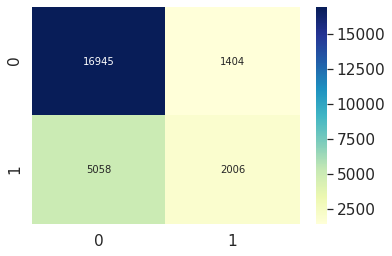

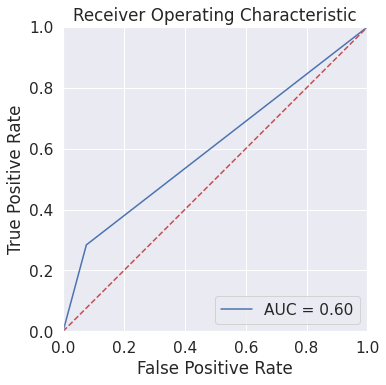

In [94]:
y_pred = tfidf_RF_model.predict(tfidf_test)
display_results(y_pred, y_test)

#### Train Random Forest (RF) Classifier using BERT Embeddings and display results

In [97]:
bert_RF_model = RandomForestClassifier(random_state=0, max_features=115).fit(bert_train, y_train)
bert_RF_model.score(bert_test, y_test)

0.6911816786683981

              precision    recall  f1-score   support

           0       0.74      0.88      0.81     18349
           1       0.39      0.19      0.26      7064

    accuracy                           0.69     25413
   macro avg       0.56      0.54      0.53     25413
weighted avg       0.64      0.69      0.65     25413



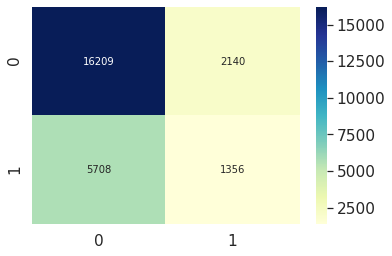

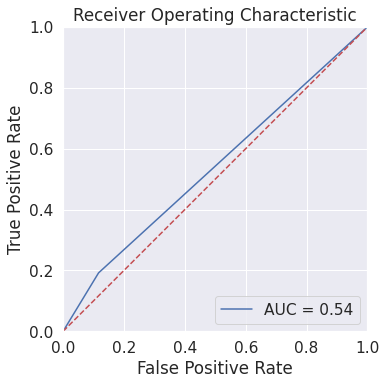

In [98]:
y_pred = bert_RF_model.predict(bert_test)
display_results(y_pred, y_test)

### Deep Learning Models

#### Train a Multi-Layer Perceptron (MLP) on TF-IDF Embeddings

##### Define the MLP

In [ ]:
tfidf_MLP = Sequential()
tfidf_MLP.add(Dense(128, activation='relu', input_dim=1000))
tfidf_MLP.add(Dropout(0.4))
tfidf_MLP.add(Dense(64, activation='relu'))
tfidf_MLP.add(Dropout(0.4))
tfidf_MLP.add(Dense(1, activation='sigmoid'))
tfidf_MLP.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])
print(tfidf_MLP.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 128)               128128    
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 65        
Total params: 136,449
Trainable params: 136,449
Non-trainable params: 0
_________________________________________________________________
None


##### Train the MLP

In [ ]:
batch_size = 32

model_save_file = main_path + "models/tfidf_MLP.hdf5"
checkpoint = ModelCheckpoint(model_save_file, monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto')

tfidf_MLP.fit(tfidf_train, y_train, batch_size=batch_size,
        epochs=10, validation_data=(tfidf_val, y_val), callbacks=[checkpoint])

Epoch 1/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.4720 - accuracy: 0.7879 - val_loss: 0.1023 - val_accuracy: 0.9652
Epoch 2/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0845 - accuracy: 0.9710 - val_loss: 0.0468 - val_accuracy: 0.9841
Epoch 3/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0374 - accuracy: 0.9875 - val_loss: 0.0372 - val_accuracy: 0.9871
Epoch 4/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0282 - accuracy: 0.9903 - val_loss: 0.0331 - val_accuracy: 0.9891
Epoch 5/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0204 - accuracy: 0.9930 - val_loss: 0.0326 - val_accuracy: 0.9897
Epoch 6/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0137 - accuracy: 0.9953 - val_loss: 0.0329 - val_accuracy: 0.9893
Epoch 7/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0150 - accuracy: 0.9951 - val_loss: 0.0328 - val_accuracy:

##### Display Results of MLP on Related/Unrelated Classification

              precision    recall  f1-score   support

           0       0.87      0.76      0.81     18349
           1       0.53      0.70      0.60      7064

    accuracy                           0.74     25413
   macro avg       0.70      0.73      0.70     25413
weighted avg       0.77      0.74      0.75     25413



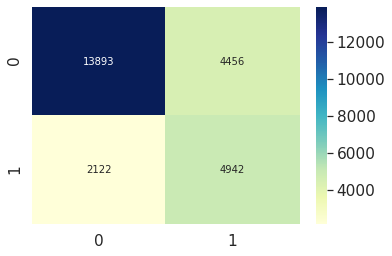

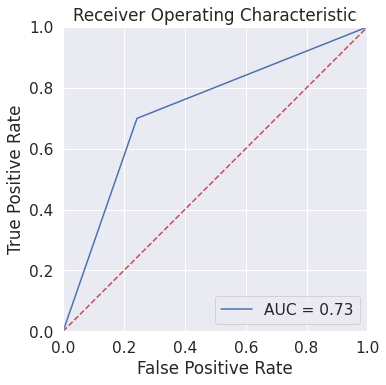

In [ ]:
tfidf_MLP = load_model(main_path + "models/tfidf_MLP.hdf5")
y_pred = (tfidf_MLP.predict(tfidf_test) > 0.5).astype("int32")
display_results(y_pred, y_test)

#### Train a Bidirectional Long Short Term Memory (Bi-LSTM) model on BERT Embeddings

##### Define the LSTM

In [90]:
# https://stackoverflow.com/questions/62281260/how-to-use-cnn-and-lstm-for-nlp-with-bert-embeddings
reshaped_bert_train = bert_train.reshape(-1, 768, 1)
reshaped_bert_val = bert_val.reshape(-1, 768, 1)

bert_LSTM = Sequential()
bert_LSTM.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(768, 1)))
bert_LSTM.add(Bidirectional(LSTM(units=64)))
bert_LSTM.add(Dense(256))
bert_LSTM.add(LeakyReLU(alpha=0.05))
bert_LSTM.add(Dense(128))
bert_LSTM.add(LeakyReLU(alpha=0.05))
bert_LSTM.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=0.001)

bert_LSTM.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'])
bert_LSTM.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_14 (Bidirectio (None, 768, 256)          133120    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 128)               164352    
_________________________________________________________________
dense_79 (Dense)             (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)               

##### Train the LSTM

In [88]:
batch_size = 32
unrelated, related = np.bincount(train_total_data['Relevance'])
total = unrelated + related

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

unrelated_weight = (1 / unrelated)*(total)/2.0 
related_weight = (1 / related)*(total)/2.0
class_weights = {0: unrelated_weight, 1: related_weight}

model_save_file = main_path + "models/advanced_bert_LSTM.hdf5"
checkpoint = ModelCheckpoint(model_save_file, monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto')

early_stopping = EarlyStopping(monitor='val_loss', verbose=0, patience=25)

history = bert_LSTM.fit(reshaped_bert_train, y_train, batch_size=batch_size,
                        epochs=200, validation_data=(reshaped_bert_val, y_val),
                        callbacks=[checkpoint, early_stopping], class_weight=class_weights)

Epoch 1/200
1250/1250 [==============================] - 174s 136ms/step - loss: 0.6921 - accuracy: 0.4775 - val_loss: 0.6930 - val_accuracy: 0.6109
Epoch 2/200
1250/1250 [==============================] - 168s 135ms/step - loss: 0.6909 - accuracy: 0.5567 - val_loss: 0.7167 - val_accuracy: 0.3880
Epoch 3/200
1250/1250 [==============================] - 167s 133ms/step - loss: 0.6854 - accuracy: 0.5670 - val_loss: 0.6849 - val_accuracy: 0.5848
Epoch 4/200
1250/1250 [==============================] - 167s 133ms/step - loss: 0.6819 - accuracy: 0.5910 - val_loss: 0.6932 - val_accuracy: 0.6237
Epoch 5/200
1250/1250 [==============================] - 167s 133ms/step - loss: 0.6856 - accuracy: 0.6193 - val_loss: 0.6786 - val_accuracy: 0.6161
Epoch 6/200
1250/1250 [==============================] - 167s 134ms/step - loss: 0.6850 - accuracy: 0.5930 - val_loss: 0.6956 - val_accuracy: 0.5944
Epoch 7/200
1250/1250 [==============================] - 167s 134ms/step - loss: 0.6791 - accuracy: 0.6429

KeyboardInterrupt: ignored

##### Display Results of LSTM on Related/Unrelated Classification

              precision    recall  f1-score   support

           0       0.75      0.65      0.70     18349
           1       0.32      0.43      0.37      7064

    accuracy                           0.59     25413
   macro avg       0.54      0.54      0.53     25413
weighted avg       0.63      0.59      0.61     25413



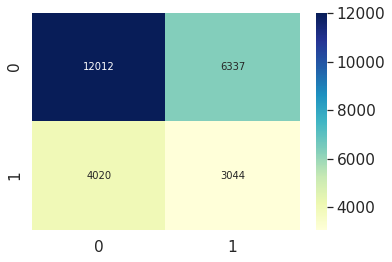

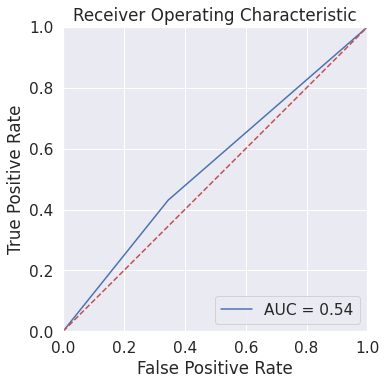

In [89]:
reshaped_bert_test = bert_test.reshape(-1, 768, 1)
bert_LSTM = load_model(main_path + "models/advanced_bert_LSTM.hdf5")
y_pred = (bert_LSTM.predict(reshaped_bert_test) > 0.5).astype("int32")
display_results(y_pred, y_test)

## Agree/Disagree/Discuss Classification

### Setting up the data

#### Select the related Headline-Body pairs and convert to integers

In [ ]:
train_related_data = train_total_data[train_total_data['Relevance'] == 1]

labels = {
    'discuss': 0,
    'agree': 1,
    'disagree': 2
}

train_related_data['Stance'] = train_related_data['Stance'].map(labels)

test_related_data = test_total_data[test_total_data['Relevance'] == 1]
test_related_data['Stance'] = test_related_data['Stance'].map(labels)

#### Split the related data into training/validation/testing sets

In [ ]:
train_input_columns_related = train_related_data[['Headline', 'articleBody']]
target = 'Stance'

X_train_related, X_val_related, y_train_related, y_val_related = train_test_split(train_input_columns_related, train_related_data[target].values, test_size=0.2, random_state=0)
y_train_related = to_categorical(y_train_related)
y_val_related = to_categorical(y_val_related)

X_test_related = test_related_data[['Headline', 'articleBody']]
y_test_related = test_related_data[['Stance']].to_numpy().ravel()
y_test_related = to_categorical(y_test_related)

print('Size of training set:  ', X_train_related.shape)
print('Size of validation set:', X_val_related.shape)
print('Size of testing set:   ', X_test_related.shape)

X_train.sample(10)

Size of training set:   (10741, 2)
Size of validation set: (2686, 2)
Size of testing set:    (7064, 2)


,Headline,articleBody
19415,who should play steve job now that christian b...,christian bale talk play steve job aaron sorki...
30416,they ate ceil poop keyboard rat take vogu s ne...,the fashion bibl ’ got decidedli unglamor rat ...
10283,kurd fear isi use chemic weapon kobani,knightscop cofound staci stephen said rumor K5...
47667,star war vii new summer releas date,two nation ’ lead expert use deadli forc polic...
22869,break soldier shot war memori ottawa,accord new york post s page six nbc sourc say ...
6463,two gop congressmen say suspect terrorist caug...,rome An italian expert studi first centuri doc...
46466,thi power cartoon about the charli hebdo attac...,thi post wide share internet yesterday work gr...
22322,christian bale play steve job upcom biopic,tokyo — kim jong Un north korean leader myster...
3368,britishborn rapper main suspect search isi jih...,A video post isil terrorist iraq purport show ...
15032,boko haram deni truce releas kidnap schoolgirl,A video surfac purport depict american journal...


### Feature Extraction

#### Compute and save BERT embeddings of train/val/test data

In [ ]:
get_bert_embedding_sets(X_train_related, X_val_related, X_test_related, 'related_')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


===Training Set===
Batch 6400
===Validation Set===
===Testing Set===
Batch 6400


#### Load BERT Embeddings

In [ ]:
bert_train_related = torch.load(main_path + 'embeddings/related_bert_train.pt').detach().cpu().numpy()
bert_val_related = torch.load(main_path + 'embeddings/related_bert_val.pt').detach().cpu().numpy()
bert_test_related = torch.load(main_path + 'embeddings/related_bert_test.pt').detach().cpu().numpy()

### Train a Bidirectional LSTM (Bi-LSTM) on BERT Embeddings 

#### Define the Bi-LSTM

In [ ]:
reshaped_bert_train = bert_train_related.reshape(-1, 768, 1)
reshaped_bert_val = bert_val_related.reshape(-1, 768, 1)

bert_LSTM_related = Sequential()
bert_LSTM_related.add(Bidirectional(LSTM(units=64, dropout=0.2, return_sequences=True), input_shape=(768, 1)))
bert_LSTM_related.add(Bidirectional(LSTM(units=32, dropout=0.2), input_shape=(768, 1)))
bert_LSTM_related.add(Dense(64))
bert_LSTM_related.add(LeakyReLU(alpha=0.05))
bert_LSTM_related.add(Dense(32))
bert_LSTM_related.add(LeakyReLU(alpha=0.05))
bert_LSTM_related.add(Dense(3, activation='softmax'))

optimizer = Adam(lr=0.001)

bert_LSTM_related.compile(optimizer=optimizer,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
bert_LSTM_related.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_8 (Bidirection (None, 768, 128)          33792     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                

#### Train the Bi-LSTM

In [ ]:
batch_size = 32
discuss, agree, disagree = np.bincount(train_related_data['Stance'])
total = agree + disagree + discuss

agree_weight = (1 / agree)*(total)/2.0 
disagree_weight = (1 / disagree)*(total)/2.0
discuss_weight = (1 / discuss)*(total)/2.0

class_weights = {0: discuss_weight, 1: agree_weight, 2: disagree_weight}

model_save_file = main_path + "models/50_dropout_2_related_LSTM.hdf5"
checkpoint = ModelCheckpoint(model_save_file, monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto')

early_stopping = EarlyStopping(monitor='val_loss', verbose=0, patience=25)

history = bert_LSTM_related.fit(reshaped_bert_train, y_train_related, batch_size=batch_size,
                        epochs=200, validation_data=(reshaped_bert_val, y_val_related),
                        callbacks=[checkpoint, early_stopping], class_weight=class_weights)

Epoch 1/200
336/336 [==============================] - 44s 118ms/step - loss: 1.6976 - accuracy: 0.1546 - val_loss: 1.0900 - val_accuracy: 0.5194
Epoch 2/200
336/336 [==============================] - 39s 116ms/step - loss: 1.6866 - accuracy: 0.2151 - val_loss: 1.0692 - val_accuracy: 0.5171
Epoch 3/200
336/336 [==============================] - 39s 115ms/step - loss: 1.6578 - accuracy: 0.3315 - val_loss: 1.0810 - val_accuracy: 0.6046
Epoch 4/200
336/336 [==============================] - 39s 116ms/step - loss: 1.6248 - accuracy: 0.4785 - val_loss: 1.0952 - val_accuracy: 0.3678
Epoch 5/200
336/336 [==============================] - 39s 116ms/step - loss: 1.6316 - accuracy: 0.3218 - val_loss: 1.0816 - val_accuracy: 0.5655
Epoch 6/200
336/336 [==============================] - 39s 116ms/step - loss: 1.6233 - accuracy: 0.4570 - val_loss: 1.0966 - val_accuracy: 0.3377
Epoch 7/200
336/336 [==============================] - 39s 115ms/step - loss: 1.6236 - accuracy: 0.4291 - val_loss: 1.1610 -

KeyboardInterrupt: ignored

#### Display the results of the Bi-LSTM on the multi-class classification problem

              precision    recall  f1-score   support

           0       0.67      0.89      0.76      4464
           1       0.47      0.26      0.34      1903
           2       0.26      0.04      0.06       697

    accuracy                           0.63      7064
   macro avg       0.47      0.39      0.39      7064
weighted avg       0.58      0.63      0.58      7064



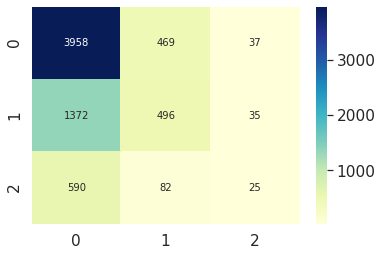

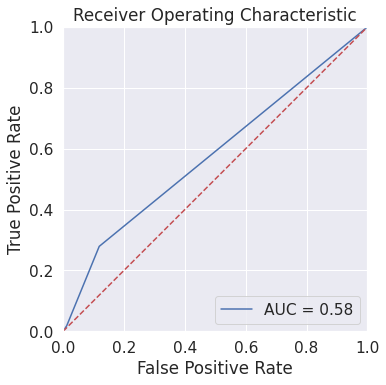

In [ ]:
reshaped_bert_test = bert_test_related.reshape(-1, 768, 1)
#bert_LSTM_related = load_model(main_path + "models/50_related_LSTM.hdf5")
y_pred = (bert_LSTM_related.predict(reshaped_bert_test) > 0.5).astype("int32")
display_results(y_pred.argmax(axis=1), y_test_related.argmax(axis=1))

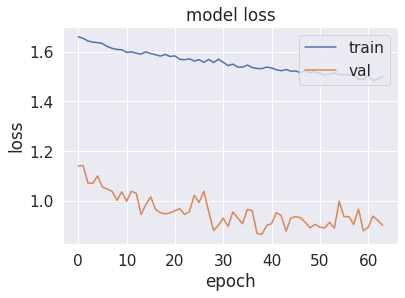

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()